# Project Title : Enhancing Credit Card Default Prediction Using GAN-Based Data Augmentation

## Import Dependencies

In [5]:
# Install the latest version (≥1.27) of the SDV library for synthetic data generation

#!pip install sdv>=1.27

In [74]:
# Basic Libraries for Data Handling & Visualization
import numpy as np                 # Numerical computations
import pandas as pd                # Data manipulation and analysis
import matplotlib.pyplot as plt    # Data visualization
from matplotlib.ticker import FuncFormatter # Formatting axis tick labels
import seaborn as sns              # Statistical data visualization
import warnings                    # To handle warning messages
warnings.filterwarnings('ignore')

# Scikit-Learn: Data Preprocessing & Model Evaluation
from sklearn.model_selection import train_test_split   # Splitting data into train/test sets
from sklearn.preprocessing import StandardScaler       # Feature scaling
from sklearn.linear_model import LogisticRegression    # Logistic Regression model
from sklearn.ensemble import RandomForestClassifier    # Random Forest model
from sklearn.preprocessing import PowerTransformer     # Transform skewed data(With large negative values) to normal
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Gradient Boosting Models
from xgboost import XGBClassifier                      # Extreme Gradient Boosting model
from lightgbm import LGBMClassifier                    # LightGBM model

# Handling Class Imbalance
from imblearn.over_sampling import SMOTE               # Synthetic Minority Over-sampling Technique

# Synthetic Data Generation using SDV (CTGAN)
from sdv.single_table import CTGANSynthesizer          # GAN-based synthetic data generator
from sdv.metadata import SingleTableMetadata           # Describe the structure and data types of a real dataset (the “metadata”).

## About Dataset
This dataset includes details on credit card clients in Taiwan, covering their demographic profiles, credit records, payment history, and billing information from April to September 2005.

## Features Overview

The dataset uses default payment (Yes = 1, No = 0) as the target variable and includes 23 explanatory features such as:

* Demographics: gender, education, marital status, and age.
* Credit details: total credit limit (NT dollar).
* Payment history: six months of repayment status records (April–September 2005).
* Billing amounts: monthly bill statements for the same period.
* Previous payments: monthly amounts paid during April–September 2005.

## Additional information

* Gender (1 = male; 2 = female).
* Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* Marital status (1 = married; 2 = single; 3 = others).

(Yeh, 2009)

Reference: Yeh, I. (2009). Default of Credit Card Clients [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C55S3H

## Load Data Set

In [7]:
# Loading Dataset & Initial Inspection

df = pd.read_excel("/content/drive/MyDrive/Navaneeth/project/default of credit card clients.xls", header=1) # 'header=1' is used because the first row contains metadata, and actual column names start from the second row

# Display the first 5 rows to verify successful loading and inspect data structure
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
# Rename target column and 'education' to 'education_level' for clarity

df.rename(columns={'default payment next month': 'default','EDUCATION': 'EDUCATION_LEVEL'}, inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION_LEVEL,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Basic Checks

In [9]:
# Check the number of rows and columns
print('Shape of the dataset:', df.shape, '\n')

# Check concise summary including column names, data types, and non-null counts
print('Summary of the DataFrame:')
df.info()

Shape of the dataset: (30000, 25) 

Summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               30000 non-null  int64
 1   LIMIT_BAL        30000 non-null  int64
 2   SEX              30000 non-null  int64
 3   EDUCATION_LEVEL  30000 non-null  int64
 4   MARRIAGE         30000 non-null  int64
 5   AGE              30000 non-null  int64
 6   PAY_0            30000 non-null  int64
 7   PAY_2            30000 non-null  int64
 8   PAY_3            30000 non-null  int64
 9   PAY_4            30000 non-null  int64
 10  PAY_5            30000 non-null  int64
 11  PAY_6            30000 non-null  int64
 12  BILL_AMT1        30000 non-null  int64
 13  BILL_AMT2        30000 non-null  int64
 14  BILL_AMT3        30000 non-null  int64
 15  BILL_AMT4        30000 non-null  int64
 16  BILL_AMT5        30000 non-null 

**Insights:**

* Dataset shape: (30,000, 25) — 30,000 records and 25 features.

* All columns are numeric (int64) with no missing values.

* Key feature groups:

     * Demographics: SEX, EDUCATION_LEVEL, MARRIAGE, AGE

    * Credit & Payments: LIMIT_BAL, PAY_0–PAY_6, BILL_AMT1–6, PAY_AMT1–6

    * Target variable: default (1 = Yes, 0 = No).

* Compact dataset (≈5.7 MB) — efficient for machine learning experiments.

In [10]:
# checking the statistical summary

df.describe().T  # Transpose (T) is used to make columns appear as rows for better readability

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION_LEVEL,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


**Insights:**

* The dataset contains 30,000 observations across 25 variables.

* Credit limit (LIMIT_BAL) ranges from 10,000 to 1,000,000 NT dollars, with a mean of ~167,484 — indicating large variation in client credit capacity.

* Age ranges from 21 to 79 years, with a median of 34, showing most clients are young to middle-aged adults.

* Education and marriage variables are encoded numerically; category labels will need mapping for better readability.

* Payment history (PAY_0–PAY_6) includes negative values (−2, −1) indicating on-time or early payments, and positive values showing delays — useful for classification modeling.

* Billing (BILL_AMT1–6) and payment (PAY_AMT1–6) amounts vary widely, suggesting possible skewness or outliers.

* The target variable default has a mean of 0.22, meaning roughly 22% of customers defaulted.

What tasks should I perform:

* Data Encoding: Replace categorical codes (e.g., education, marriage) with descriptive labels during Exploratory Data Analysis.

* Feature Scaling: Apply normalization or standardization due to large value ranges in LIMIT_BAL, BILL_AMT, and PAY_AMT.

* Outlier Treatment: Examine extreme billing and payment values for potential outliers.

* Class Balance Check: Since only 22% defaulted, consider SMOTE or other resampling methods to balance the target variable before model training.

In [11]:
# Checking missing values

df.isna().sum()

,0
ID,0
LIMIT_BAL,0
SEX,0
EDUCATION_LEVEL,0
MARRIAGE,0
AGE,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0


**Insights:**
* There is no missing data in the this dataset.

In [12]:
# check if any infinite values

np.isinf(df).sum()

,0
ID,0
LIMIT_BAL,0
SEX,0
EDUCATION_LEVEL,0
MARRIAGE,0
AGE,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0


**Insights:**
* There is no infinites data in the this dataset.

## Exploratory Data Analysis(EDA)

### Checking Class Distribution

In [13]:
# Checking proportion of defaulters vs non-defaulters

class_count_proportion = df['default'].value_counts(normalize=True).apply(lambda x: f'{x*100:.2f}%')
class_count_proportion

,proportion
default,
0,77.88%
1,22.12%


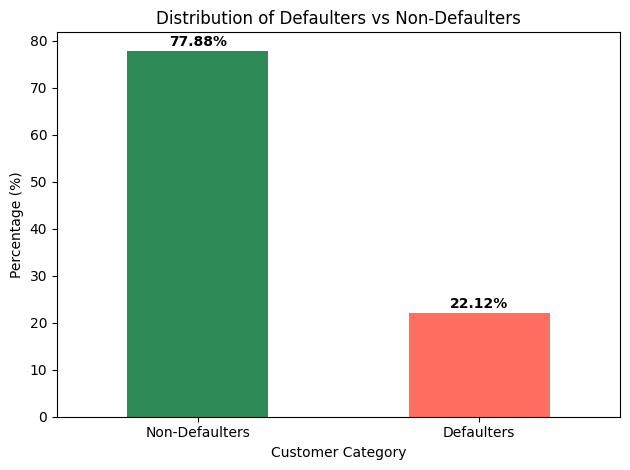

In [14]:
# Plotting distribution of defaulters vs non-defaulters

class_count = df['default'].value_counts(normalize=True) * 100

# Define custom labels
labels = ['Non-Defaulters', 'Defaulters']

# Plot
ax = class_count.plot(
    kind='bar',
    color=['#2E8B57', '#FF6F61'],
    title='Distribution of Defaulters vs Non-Defaulters'
)

# Replace x-tick labels from 1 to defaulters & 0 to non-defaulters
ax.set_xticklabels(labels, rotation=0)

# Add percentage labels on bars
for i, v in enumerate(class_count):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=10, fontweight='bold')

# Labels and layout
plt.xlabel('Customer Category')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()


**Insights:**

* The dataset shows a clear class imbalance between defaulters and non-defaulters.

* Around 77.88% of customers did not default, while only 22.12% defaulted on payments.

* This imbalance indicates that the dataset is skewed toward non-defaulters, which may affect model performance.

* To ensure fair prediction accuracy, resampling techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or GAN should be applied before model training.

In [15]:
# Getting columns name

df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION_LEVEL', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

## Univariate Analysis

### Univariate Analysis for numerical  Feature

In [16]:
# Create a function to Plot Univariate Histograms for Numerical Features

def hist_plot(df, col):
    """
    Plot a histogram showing the distribution of a numerical feature.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset containing the feature to visualize.
    col : str
        The column name of the numerical feature to plot.

    Description
    -----------
    This function creates a clean histogram for the given numeric column to
    visualize its distribution, detect skewness, and identify potential outliers.
    """

    # Create figure and define plot size
    plt.figure(figsize=(8,6))

    # Plot histogram with custom color, edge, and transparency
    plt.hist(df[col], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7)

    # Add title and axis labels
    plt.title(f"{col} Distribution", fontsize=16)
    plt.xlabel(f"{col}", fontsize=12)
    plt.ylabel("Number of Clients", fontsize=12)

    # Format x-axis to show full numbers (e.g., 100,000 instead of 0.1e6)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

    # Add light grid and adjust layout
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


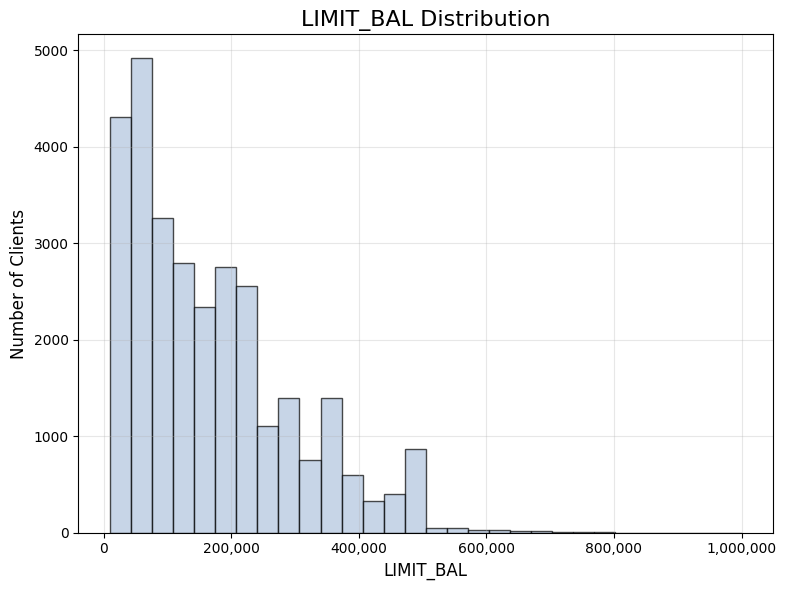

In [17]:
# Visualizing Distribution of Credit Limit (LIMIT_BAL)

hist_plot(df, "LIMIT_BAL")

**Insights:**

* The distribution of credit limits (LIMIT_BAL) is right-skewed, meaning most clients have lower credit limits.

* A large number of clients have limits below 200,000 NT dollars, while only a few exceed 500,000 NT dollars.

* The wide range of credit limits (10,000 to 1,000,000) indicates high variability among clients’ credit capacities.

What tasks should I perform:

* Apply scaling or normalization (e.g., StandardScaler or MinMaxScaler) before model training to handle large numeric ranges.

* Consider log transformation of LIMIT_BAL to reduce skewness and improve model stability.

* During analysis, explore how credit limit correlates with default rate — high or low limits may influence risk levels.

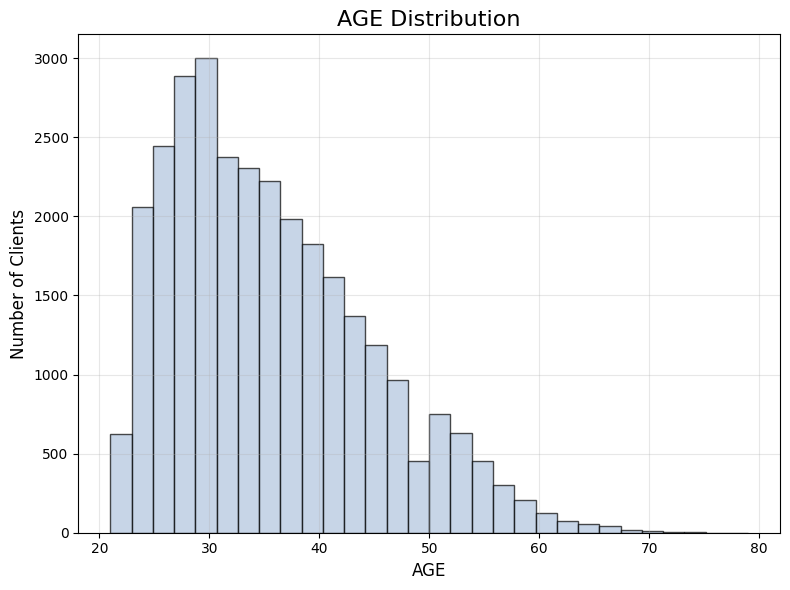

In [18]:
# Visualizing Age Distribution of Clients

hist_plot(df, "AGE")

**Insights:**

* The age distribution is slightly right-skewed, with most clients between 25 and 40 years old.

* The number of clients gradually declines after age 40, and very few are above 60.

* This suggests that the majority of credit card holders are younger working adults, likely at the early to mid-stage of their financial lifecycle.

What task I should perform:
* Test whether age correlates with default rates — younger clients might show different payment behaviours than older ones.

### Univariate Analysis for Categorical feature

In [19]:
# Create function to Plot Univariate Countplots for Categorical Features

def count_plot(df, col):
    """
    Create a countplot to visualize the distribution of a categorical feature.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset containing the categorical feature.
    col : str
        The column name of the categorical variable to plot.

    Description
    -----------
    This function uses seaborn's countplot to show how frequently each category
    appears in the dataset. It helps identify class imbalance or dominant groups
    within categorical variables.
    """

    # Create a countplot for the selected categorical feature
    sns.countplot(x=col, data=df, palette='cool')

    # Add title and axis labels
    plt.title(f"{col} Distribution", fontsize=14)
    plt.xlabel(f"{col}", fontsize=12)
    plt.ylabel("Number of Clients", fontsize=12)

    # Display category names clearly on the x-axis
    plt.xticks(rotation=0)

    # Show the plot
    plt.show()


In [20]:
# Creating a Readable Copy of Dataset with Categorical Labels


df_copy = df.copy() # Create a copy of the original dataset to preserve raw data

# Define mapping dictionaries to convert numerical category codes into meaningful labels
sex_map = {
    1: 'Male',
    2: 'Female'
}

edu_map = {
    1: 'Graduate School',
    2: 'University',
    3: 'High School',
    4: 'Others',
    0: 'Unknown',
    5: 'Unknown',
    6: 'Unknown'
}

marriage_map = {
    1: 'Married',
    2: 'Single',
    3: 'Others',
    0: 'Unknown'
}

# Apply mappings to convert numeric categories into descriptive strings
df_copy['SEX'] = df_copy['SEX'].map(sex_map)
df_copy['EDUCATION_LEVEL'] = df_copy['EDUCATION_LEVEL'].map(edu_map)
df_copy['MARRIAGE'] = df_copy['MARRIAGE'].map(marriage_map)

# The new df_copy now contains human-readable categorical values for analysis and visualization



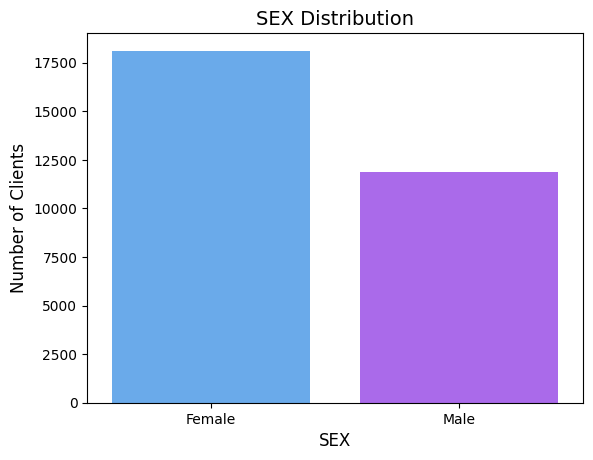

In [21]:
# Visualizing Gender Distribution of Clients

count_plot(df_copy, 'SEX')

**Insight:**

* The dataset shows a higher proportion of female clients than male clients.

* Approximately 60% of customers are female, compared to 40% male, indicating a gender imbalance in the credit card client base.

* This may reflect greater credit card ownership or approval among female clients during the study period in Taiwan.

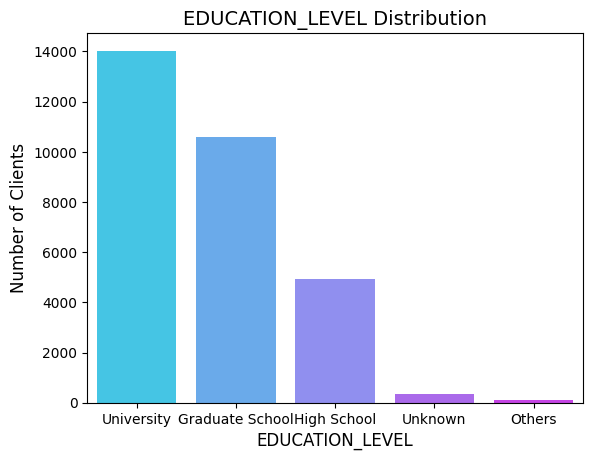

In [22]:
# Visualizing Education Level Distribution of Clients

count_plot(df_copy, 'EDUCATION_LEVEL')

**Insight:**

* The dataset shows that most clients are university graduates, followed by those with graduate school education, while high school–educated clients form a smaller group.
* Very few records fall under “Others” or “Unknown,” indicating good data quality.

This distribution suggests that the credit card customer base is predominantly well-educated, which may influence credit behavior and model outcomes.

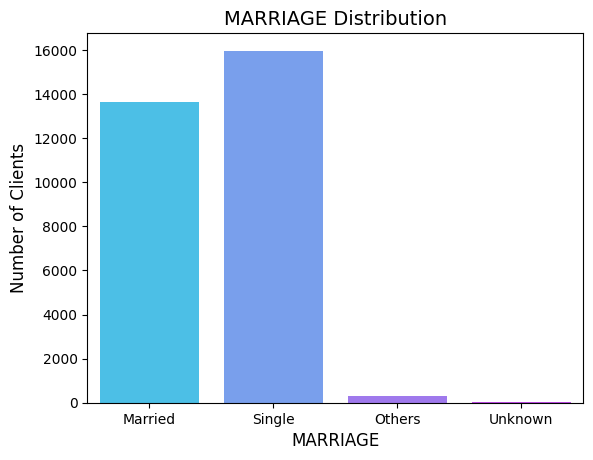

In [23]:
# Visualizing Marital Status Distribution of Clients

count_plot(df_copy, 'MARRIAGE')

**Insights:**

* The dataset shows that single clients form the largest group, closely followed by married clients.

* A very small portion of the dataset falls under “others” or “unknown” categories.

* This suggests a balanced marital profile between single and married individuals, providing useful diversity for analysis.

Marital status could be a significant factor influencing default behaviour, as financial responsibilities and spending patterns often differ between single and married clients.

In [24]:
# Creating Feature Groups for Thematic Visualization

# Payment Delay Features - These columns indicate the repayment status (delay in months) for the last 6 billing periods
df_delay = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]

# Amounts Billed (Outstanding Balances) - These represent the billed amount for each of the past 6 months
df_owed = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]

# Amounts Paid - These columns show the payment amount made by the client for each of the past 6 months
df_paid = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

# Each grouped dataset will help visualize trends in delay, billing, and payment patterns over time


In [25]:
# Create function to Visualize Distribution of Six Related Features

def six_distribution(df_input):
    """
    Plot histograms for up to six numerical features to see their distributions together.

    Parameters
    ----------
    df_input : pandas.DataFrame
        A DataFrame containing up to six related numerical columns
        (e.g., payment delays, billed amounts, or paid amounts).

    Description
    -----------
    This function creates a 3x2 grid of histograms to visualize the distribution
    of six related features simultaneously. It’s especially useful for
    identifying patterns, skewness, and outliers across sequential time-based
    variables such as monthly billing or payment histories.
    """

    # Set figure size for all subplots
    plt.figure(figsize=(12, 10))
    plotnumber = 1

    # Iterate over each column and create individual histogram subplots
    for column in df_input.columns:
        if plotnumber <= 6:
            ax = plt.subplot(3, 2, plotnumber)
            df_input[column].hist(bins=20, color='lightpink', edgecolor='black')

            # Format x-axis to show full numbers (e.g., 100,000 instead of 0.1e6)
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

            # Set title, labels, and tick formatting
            plt.title(f"{column} Distribution", fontsize=12, fontweight='bold')
            plt.xlabel(column)
            plt.ylabel("Number of Clients")
            plt.xticks(rotation=30)

        plotnumber += 1

    # Adjust spacing between plots
    plt.tight_layout()
    plt.show()


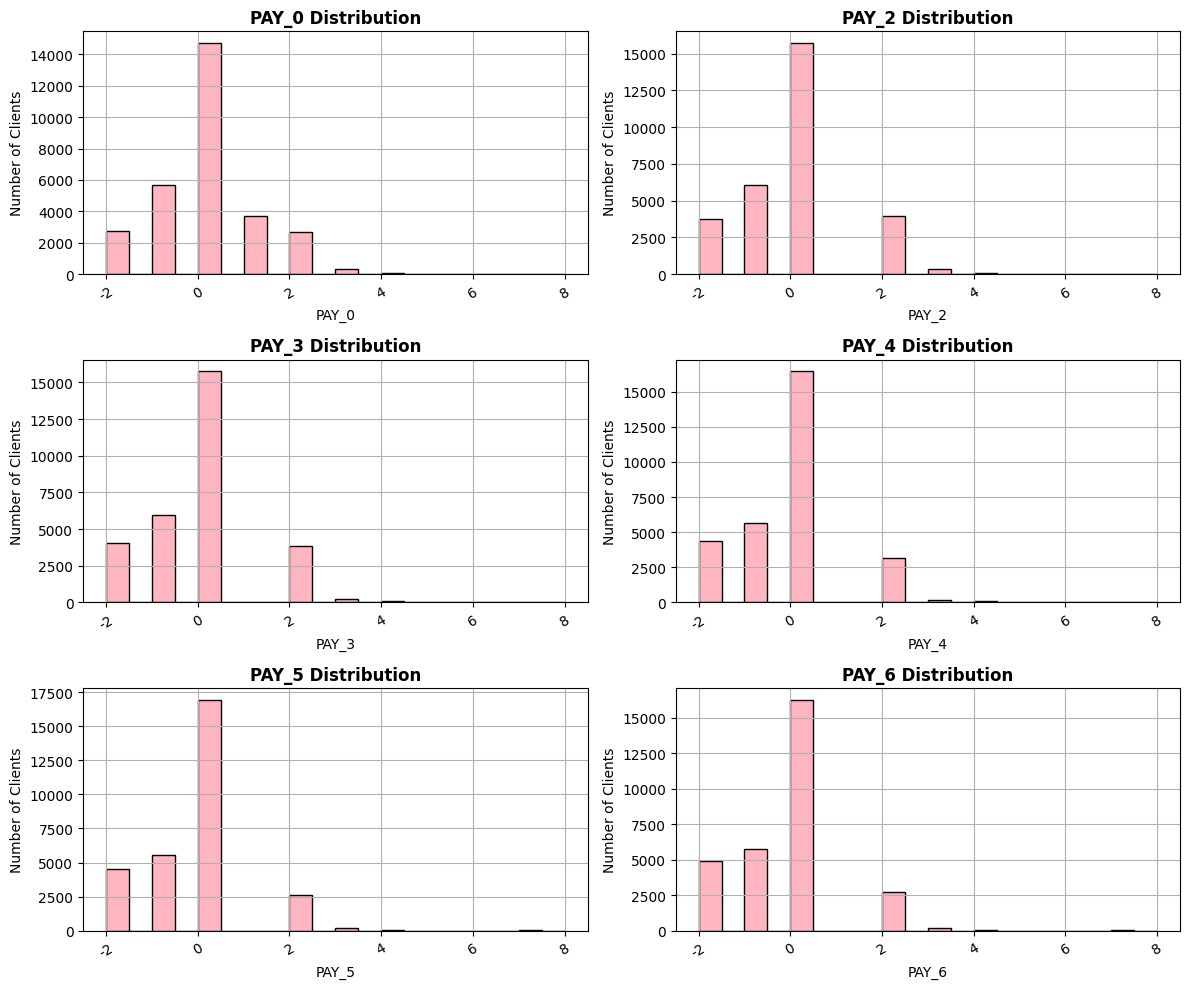

In [26]:
# Visualizing Payment Delay Distribution (how delay patterns change over time in Last 6 Months)

six_distribution(df_delay)

**Insights:**

* Most clients have payment statuses around 0, showing timely payments, while a few have higher values (>2) indicating delayed payments and potential default risk.
* Negative values (−1, −2) represent early or full payments. The pattern is consistent across all months, meaning customer behavior is stable over time. Since PAY_0–PAY_6 are ordinal categories, not continuous values, they shouldn’t be log-transformed — instead, keep them as numeric labels or categorical features for modeling.

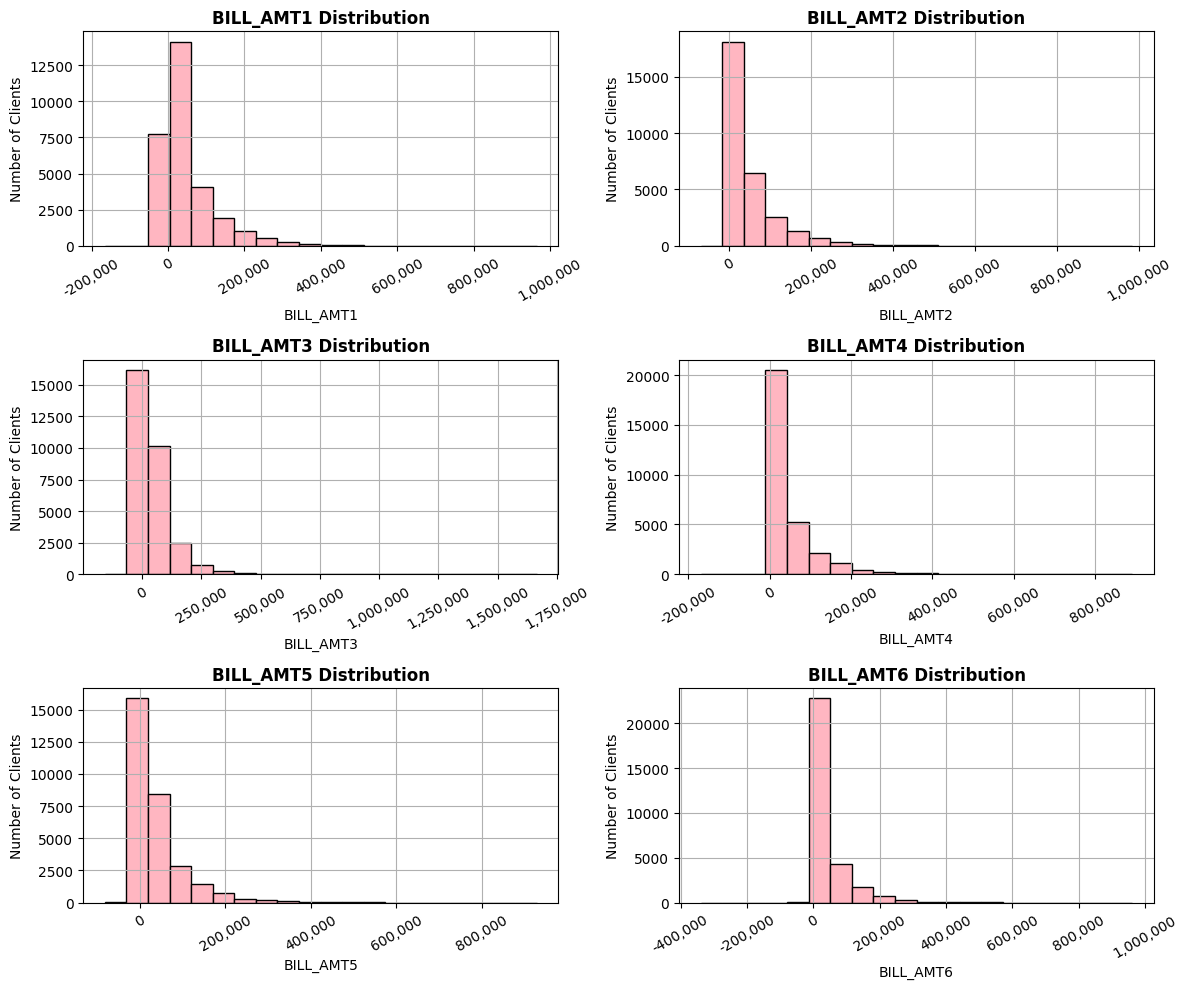

In [27]:
# Visualizing Bill Amount Distribution (debt patterns over time in last 6 Months)

six_distribution(df_owed)

**Insights:**

* All six bill amount features (BILL_AMT1–BILL_AMT6) show a right-skewed distribution, meaning most clients have relatively low outstanding balances, while a few have very high bill amounts.

* The concentration of values near zero suggests that a majority of clients pay off most of their balance regularly, reducing their month-end bill amount.

* Some negative values appear, which may represent overpayments or data entry adjustments.So, we can not use log transformation instead we will use PowerTransformer to convert to normal distribution

The overall pattern is consistent across all six months, indicating stable billing trends over time.

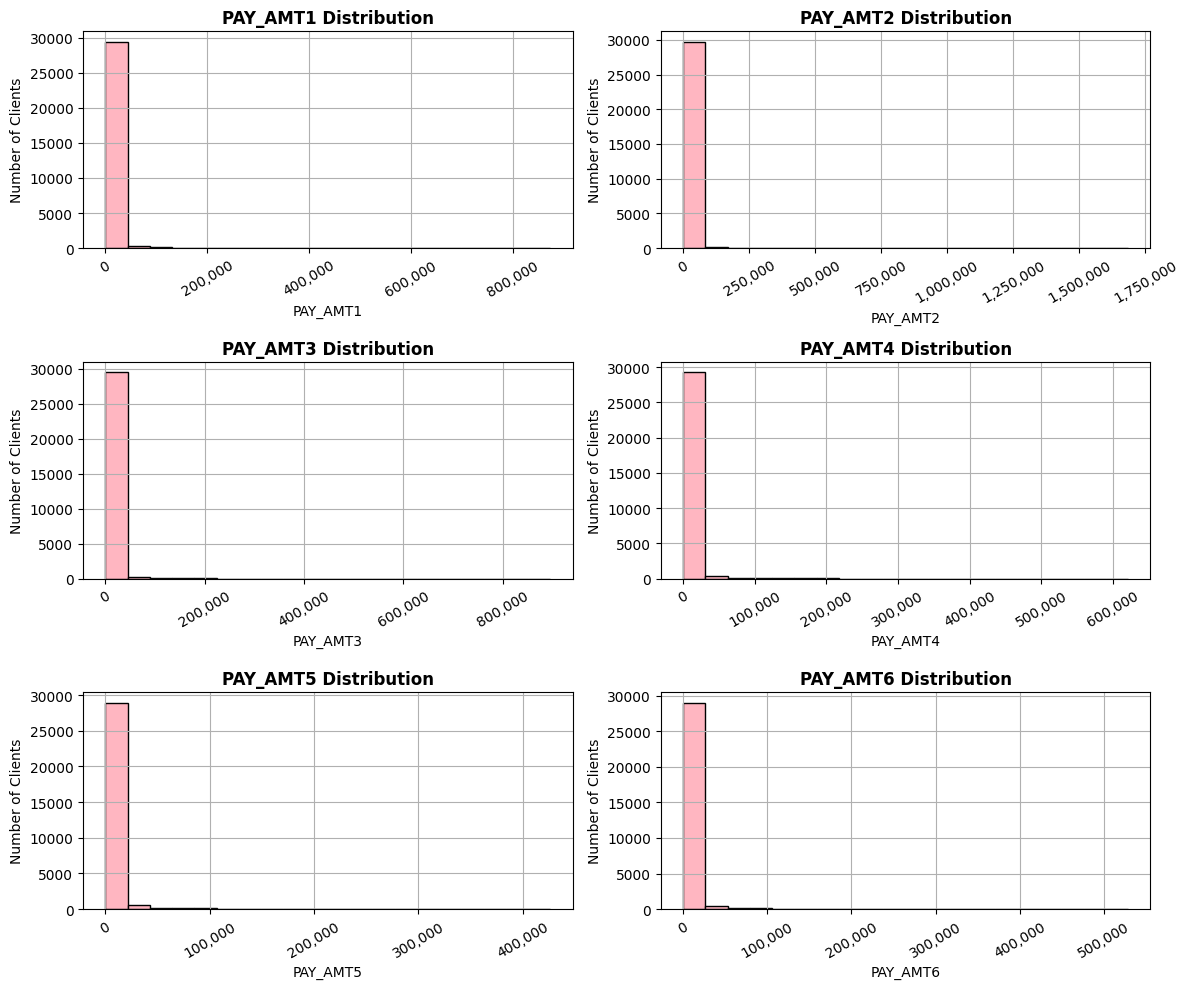

In [28]:
# Visualizing Payment Amount Distribution (Detecting irregular payment patterns in last 6 Months)

six_distribution(df_paid)

**Insights:**

* The payment amount distributions (PAY_AMT1–PAY_AMT6) are highly right-skewed, showing that most clients make small payments, while a few pay very large amounts.

* The sharp concentration near zero suggests that a **significant portion of clients paid little or nothing in certain months**.

* A few extreme values represent high-paying clients or outliers, possibly those clearing large debts.

The pattern remains consistent across all six months, reflecting stable monthly payment behaviour.

##  Bi-Variate Analyis

### Default Rate by Education, Gender, and Marital Status

In [29]:
# Create function to Plot Default Rate by Categorical Feature

def plot_default_rate(df, column, title, xlabel, ylabel):
    """
    Plot the default rate (percentage of defaulters) for each category of a given feature.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset containing the feature and 'default' column.
    column : str
        The categorical column name for which to compute and visualize default rates.
    title : str
        The title of the plot.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis.

    Description
    -----------
    This function groups the dataset by a categorical feature, calculates the mean
    default rate (proportion of defaulters) for each category, and visualizes it
    using a bar chart. It helps identify categories with higher or lower likelihood
    of default — valuable for credit risk analysis and feature importance exploration.
    """

    # Set figure size
    plt.figure(figsize=(8,6))

    # Calculate mean default rate per category
    rate = df.groupby(column)['default'].mean().reset_index()

    # Create a barplot of default rate per category
    sns.barplot(x=column, y='default', data=rate, palette='coolwarm')

    # Add titles and axis labels
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # Add horizontal gridlines for better readability
    plt.grid(axis='y', alpha=0.3)

    # Annotate bars with default rate percentages
    for index, row in rate.iterrows():
        plt.text(index, row['default'] + 0.005, f"{row['default']*100:.1f}%",
                 ha='center', fontsize=10, fontweight='bold')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

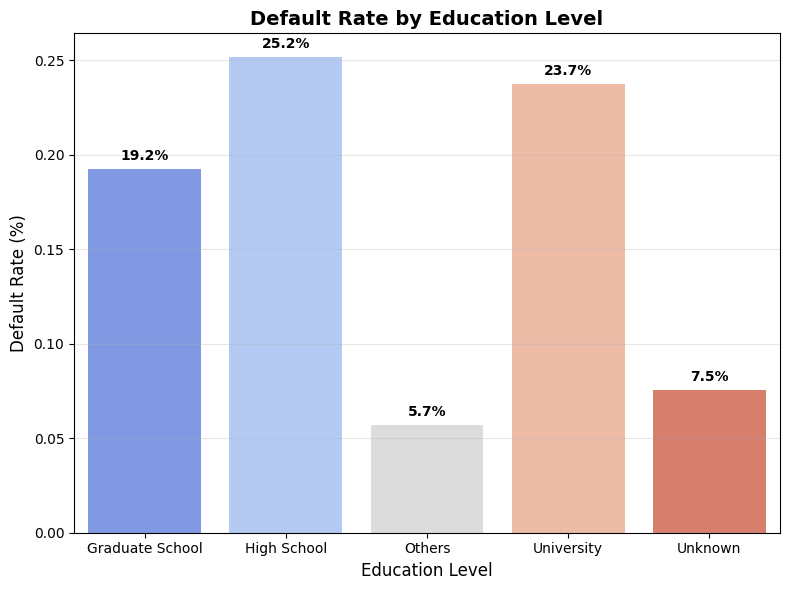

In [30]:
#  Default rate by Education Level

plot_default_rate(
    df_copy,
    column='EDUCATION_LEVEL',
    title='Default Rate by Education Level',
    xlabel='Education Level',
    ylabel='Default Rate (%)'
    )

**Insights:**

* Clients with a high school education show the highest default rate (25.2%), followed by university graduates (23.7%).

* Those with graduate-level education have a lower default rate (19.2%), indicating a possible link between higher education and stronger financial responsibility.

* The “others” and “unknown” categories display unusually low default rates, likely due to smaller sample sizes or incomplete data.

Overall, education level appears to influence default behaviour, with individuals having lower education levels tending to default more frequently.

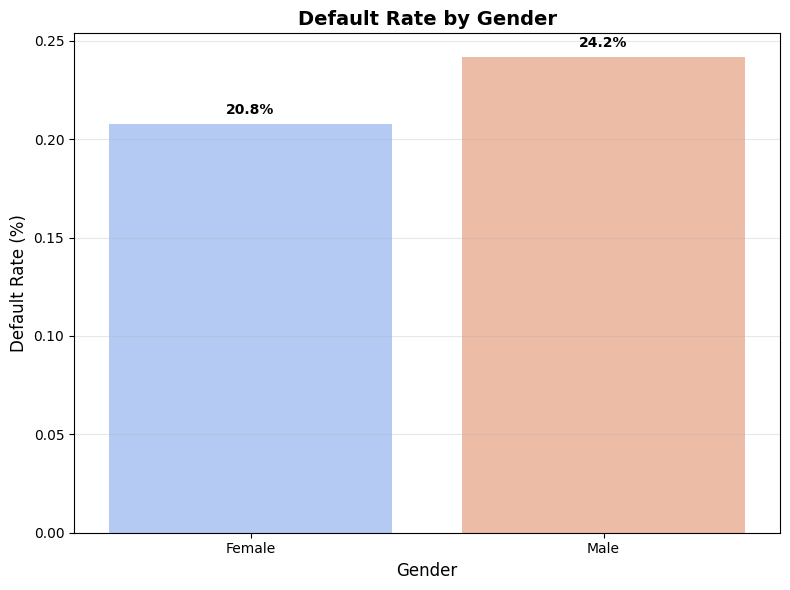

In [31]:
# Default rate by Gender

plot_default_rate(
    df_copy,
    column='SEX',
    title='Default Rate by Gender',
    xlabel='Gender',
    ylabel='Default Rate (%)'
)

**Insights:**

* The default rate among male clients (24.2%) is slightly higher than that of female clients (20.8%).

* This suggests that male customers are marginally more likely to default compared to females in this dataset.

* The difference, while not extreme, could indicate variations in spending or repayment behaviour between genders.

Gender, therefore, can be considered a moderate predictive factor for credit default but should be used cautiously to avoid bias in model interpretation or decision-making.

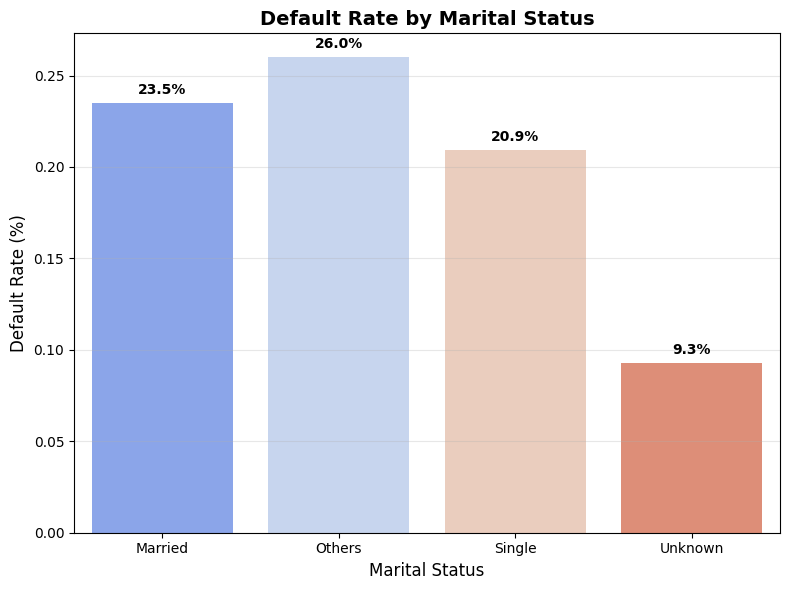

In [32]:
# Default rate by Marital Status

plot_default_rate(
    df_copy,
    column='MARRIAGE',
    title='Default Rate by Marital Status',
    xlabel='Marital Status',
    ylabel='Default Rate (%)'
)

**Insights:**

* Married clients have a slightly higher default rate (23.5%) than single clients (20.9%), suggesting marital responsibilities may influence repayment behaviour.

* The “others” category shows the highest default rate (26%), possibly due to irregular income patterns or smaller group size.

* Unknown marital status records the lowest default rate (9.3%), likely a data anomaly or due to limited sample representation.

Overall, the variation in default rates across marital categories indicates that marital status has a moderate relationship with credit risk and can be included as a categorical predictor in the model.

### Boxplot of Credit Limit vs Default

In [33]:
# Function to Visualize Numeric Feature Distribution by Default Status (Boxplot)

def boxplot_feature_vs_default(df, feature, title, xlabel, ylabel):
    """
    Create a boxplot to compare the distribution of a numeric feature
    between defaulters and non-defaulters.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset containing both the feature and the 'default' column.
    feature : str
        The numeric feature to visualize against the default variable.
    title : str
        The title of the plot.
    xlabel : str
        Label for the x-axis (typically 'Default Status').
    ylabel : str
        Label for the y-axis (the feature name).

    Description
    -----------
    This function uses seaborn's boxplot to visualize how a numeric feature
    (e.g., LIMIT_BAL, AGE, BILL_AMT, or PAY_AMT) varies between clients
    who defaulted and those who did not.
    It helps identify differences in central tendency, spread, and potential
    outliers across the two groups — valuable for understanding feature impact
    on default behavior.
    """

    # Set figure size
    plt.figure(figsize=(8,6))

    # Create the boxplot (without outliers for cleaner view)
    sns.boxplot(x='default', y=feature, data=df, palette='Set2', showfliers=False)

    # Add title and axis labels
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # Add horizontal gridlines for better readability
    plt.grid(axis='y', alpha=0.3)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


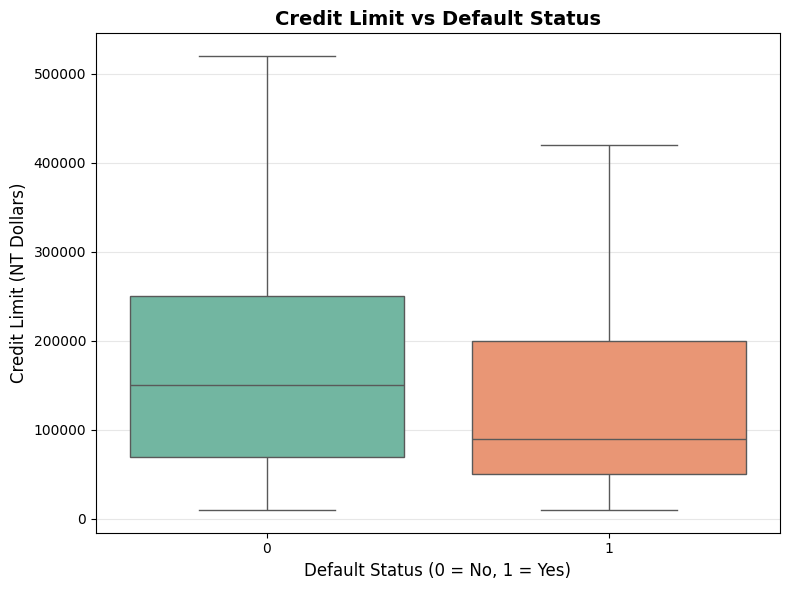

In [34]:
# Credit Limit vs Default Status

boxplot_feature_vs_default(
    df=df,
    feature='LIMIT_BAL',
    title='Credit Limit vs Default Status',
    xlabel='Default Status (0 = No, 1 = Yes)',
    ylabel='Credit Limit (NT Dollars)'
)


**Insights:**

* The median credit limit for defaulters is noticeably lower than that of non-defaulters, indicating that clients with smaller credit limits are more prone to default.

* Non-defaulters generally have a wider range of credit limits, suggesting that higher-limit customers tend to manage repayments more responsibly.

* The interquartile range (IQR) for defaulters is narrower, meaning most defaults occur among customers with moderate to low credit limits.

The presence of high-limit outliers among non-defaulters indicates that creditworthy clients are often granted higher limits and maintain good repayment behaviour.

### Mean Payment Delay by Default Status

<Figure size 800x600 with 0 Axes>

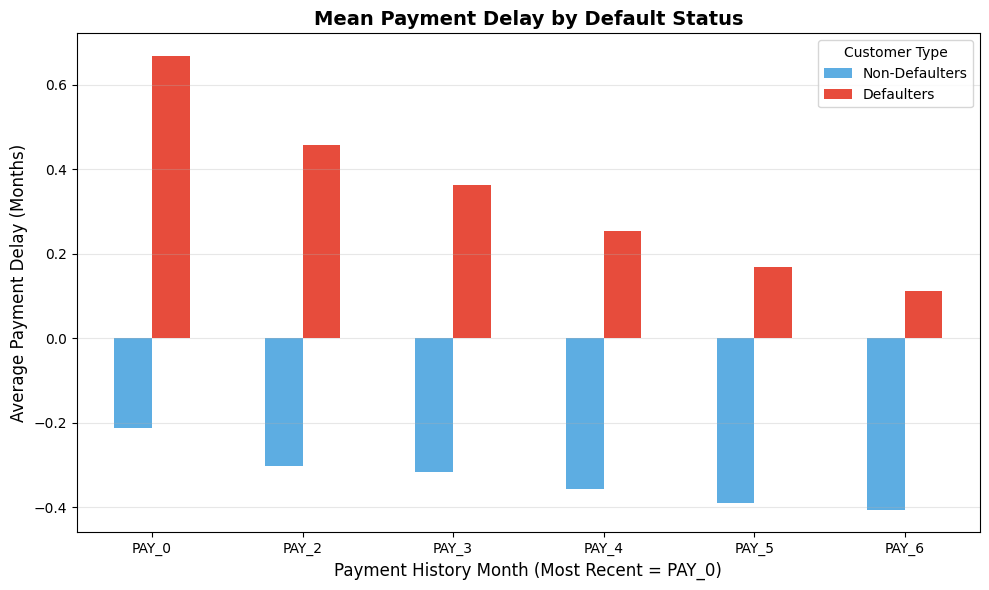

In [35]:
# Analyzing Mean Payment Delay by Default Status

# Define columns representing repayment status over the last six billing months
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Calculate average payment delay for each default category (0 = No, 1 = Yes)

mean_delay = df.groupby('default')[pay_cols].mean().T # Transpose the result for clearer bar chart plotting
mean_delay.columns = ['Non-Defaulters', 'Defaulters']  # Rename columns for clarity

# Create bar chart comparing average delay per month for defaulters vs non-defaulters
plt.figure(figsize=(8,6))
mean_delay.plot(kind='bar', figsize=(10,6), color=['#5DADE2', '#E74C3C'])

# Add titles, labels, and formatting
plt.title('Mean Payment Delay by Default Status', fontsize=14, fontweight='bold')
plt.xlabel('Payment History Month (Most Recent = PAY_0)', fontsize=12)
plt.ylabel('Average Payment Delay (Months)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Customer Type')
plt.tight_layout()

# Display the plot
plt.show()


**Insights:**

* Across all months (PAY_0–PAY_6), defaulters consistently show positive mean payment delay values, indicating frequent late payments.

* Non-defaulters, on the other hand, maintain negative or near-zero delay values, meaning they pay on time or early.

* The gap between the two groups is largest in recent months (PAY_0, PAY_2), suggesting that recent payment behaviour is a strong indicator of default risk.

The overall trend highlights a persistent repayment pattern — clients who delay once are likely to continue doing so.

What tasks should I perform:

* Include PAY_0 to PAY_6 as key predictors in model training, since they strongly distinguish between default and non-default behaviour.

* Consider aggregating delay features (e.g., average or maximum delay) to simplify model complexity.

* Use recent payment variables (PAY_0, PAY_2) with higher weights or feature importance, as they provide the strongest predictive signal.

* Explore whether combining payment delay trends with bill and payment amounts enhances model accuracy for predicting default probability.

## Checking Correlation heatmap

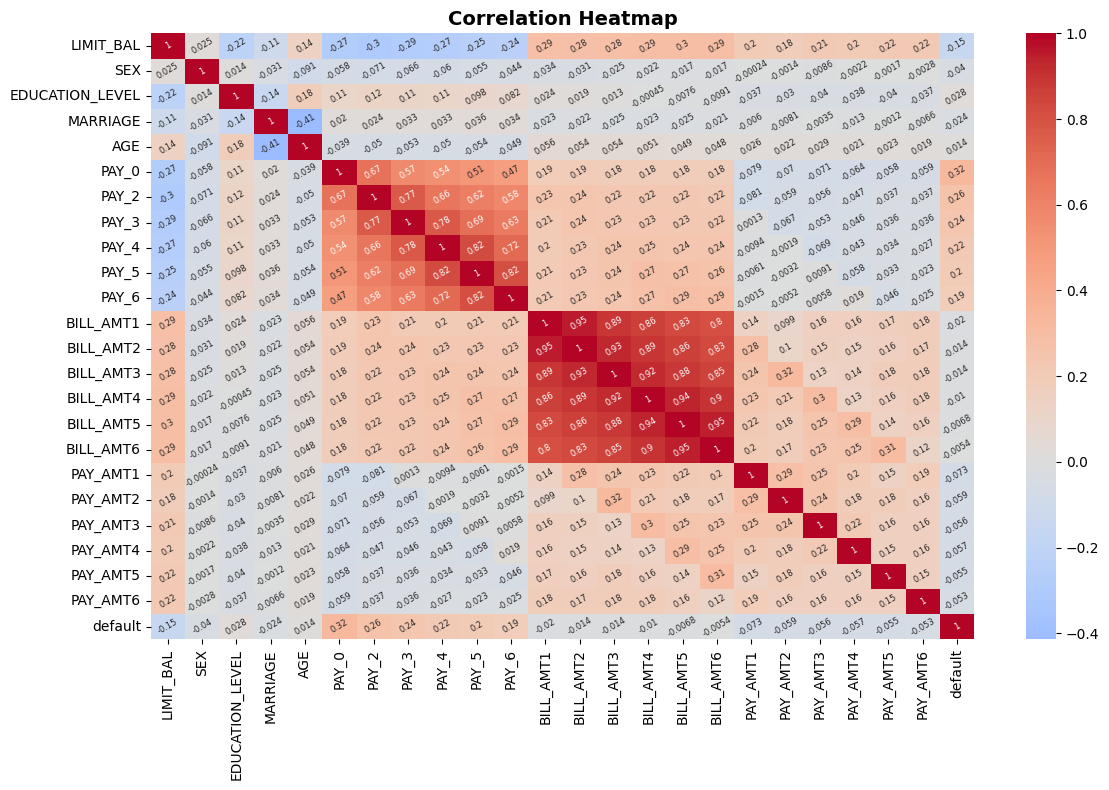

In [36]:
# Correlation Heatmap of Features

# Create a correlation matrix excluding the 'ID' column (non-predictive)
plt.figure(figsize=(12,8))
corr = df.drop('ID', axis=1).corr()

# Plot the correlation heatmap
sns.heatmap(
    corr,
    cmap='coolwarm',        # Diverging color palette (red–blue)
    center=0,               # Center the colormap at zero
    annot=True,             # Display correlation coefficients
    annot_kws={"size":6, "rotation":30}  # Annotation style
)

# Add title and display
plt.title("Correlation Heatmap", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**Insights:**

* The correlation heatmap shows strong positive relationships among consecutive bill amount (BILL_AMT1–BILL_AMT6) and payment amount (PAY_AMT1–PAY_AMT6) variables — indicating consistent financial behaviour over time.

* Payment delay variables (PAY_0–PAY_6) also show moderate positive correlation with each other, reflecting repeated late-payment tendencies in some clients.

* A negative correlation exists between credit limit (LIMIT_BAL) and default, suggesting clients with higher credit limits are less likely to default.

* The strongest correlations are observed within the same feature groups (bill and payment amounts), while demographic features like SEX, EDUCATION_LEVEL, and MARRIAGE show weak correlations with default behaviour.

Overall, payment history and billing behaviour appear to be the most influential predictors of credit default risk.

What tasks  should I perform:

* Feature Selection: Focus on highly correlated groups such as PAY_x, BILL_AMTx, and PAY_AMTx as key predictors for default risk.

* Multicollinearity Check: Since many billing and payment variables are strongly correlated, use dimensionality reduction (e.g., PCA) to avoid redundancy.

* Model Optimization: Consider tree-based models (e.g., Random Forest, XGBoost) that handle correlated features well.

* Feature Scaling: Apply scaling or normalization to continuous features like LIMIT_BAL, BILL_AMTx, and PAY_AMTx to improve model convergence.

* Feature Engineering: Create derived features, such as average delay, total bill-to-payment ratio, or trend indicators, to capture long-term payment behaviour patterns.

In [37]:
# Identify Top Correlated Features with 'Default'

# Compute correlation values between all features and the target variable ('default')
corr_target = corr['default'].sort_values(ascending=False)

# Display the top 10 features most positively or negatively correlated with default
print("\nTop features correlated with default:")
corr_target.head(10)



Top features correlated with default:


,default
default,1.000000
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149
PAY_6,0.186866
EDUCATION_LEVEL,0.028006
AGE,0.013890
BILL_AMT6,-0.005372


**Insights:**

* The features PAY_0 to PAY_6 (payment delay history) show the strongest positive correlation with the default variable, especially PAY_0 (r = 0.32), indicating that recent payment behaviour is a key predictor of default.

* The correlation gradually decreases for earlier payment months (PAY_6), confirming that recent delays impact default risk more strongly than older ones.

* Education level and age have very weak correlations with default, suggesting limited influence on repayment outcomes.

* The slight negative correlation of BILL_AMT6 implies that higher bill amounts do not necessarily increase default risk, likely due to responsible high-credit clients maintaining timely payments.

Overall, payment history features dominate as the most informative predictors for credit default modelling.

## Data Preprocessing

### Log Transformation for Skewed Features

In [38]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION_LEVEL', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [39]:
# Create Log Transformation Function

def log_transformation(ds, column):
    """
    Apply a natural log (log1p) transformation to a numerical column.

    Parameters
    ----------
    ds : pandas.DataFrame
        The dataset containing the column to be transformed.
    column : str
        The name of the numeric column to apply log transformation on.

    Returns
    -------
    pandas.DataFrame
        The dataset with the specified column transformed using log1p.

    Description
    -----------
    The log transformation helps to reduce right skewness in features
    with large positive values and stabilize variance.
    `np.log1p()` is used instead of `np.log()` to safely handle zero values
    (since log(0) is undefined).
    """
    ds[column] = np.log1p(ds[column])  # Add 1 to avoid log(0)
    return ds


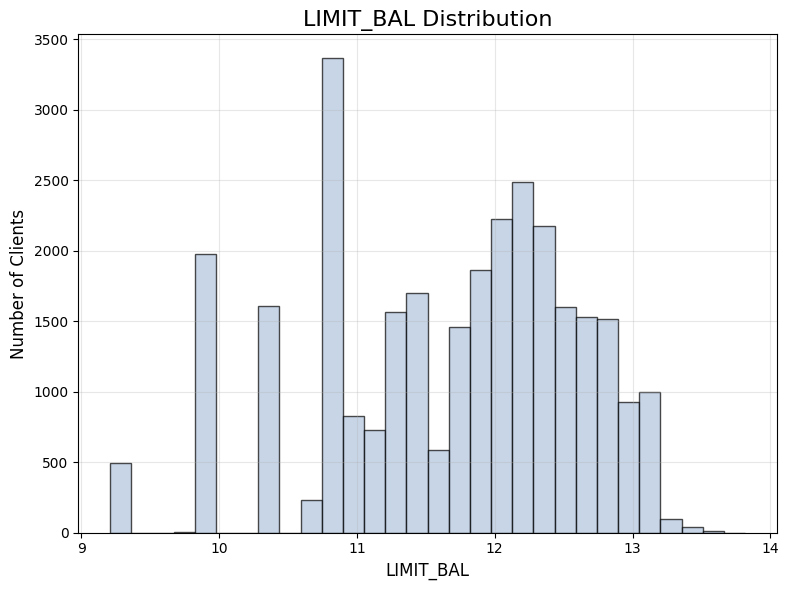

In [40]:
# Log Transformation 'LIMIT_BAL'

log_transformation(df, 'LIMIT_BAL')

# Histogram for LIMIT_BAL to check transformation
hist_plot(df, "LIMIT_BAL")

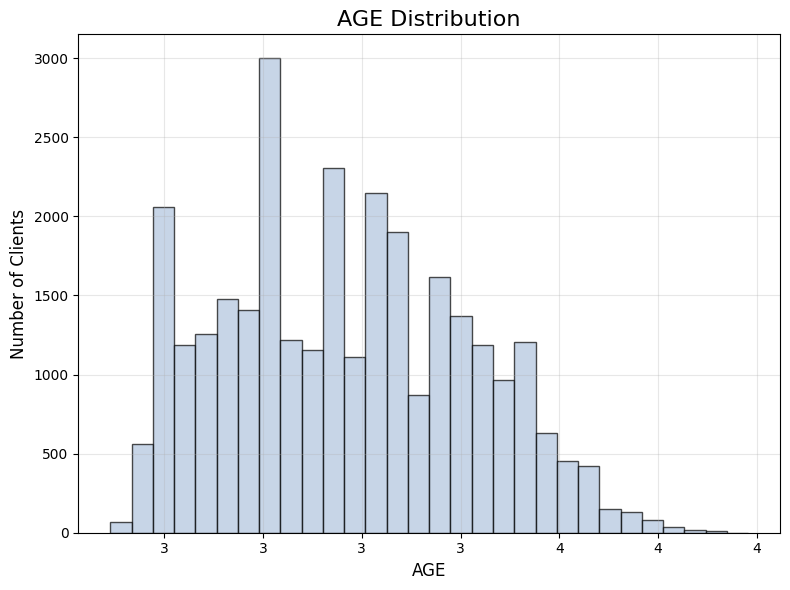

In [41]:
# Log Transformation 'AGE'

log_transformation(df, 'AGE')

# Histogram for 'AGE' to check transformation
hist_plot(df, 'AGE')

In [42]:
# Apply Log Transformation to All Payment Amount Columns

for col in df_paid.columns:
    df_paid = log_transformation(df_paid, col)

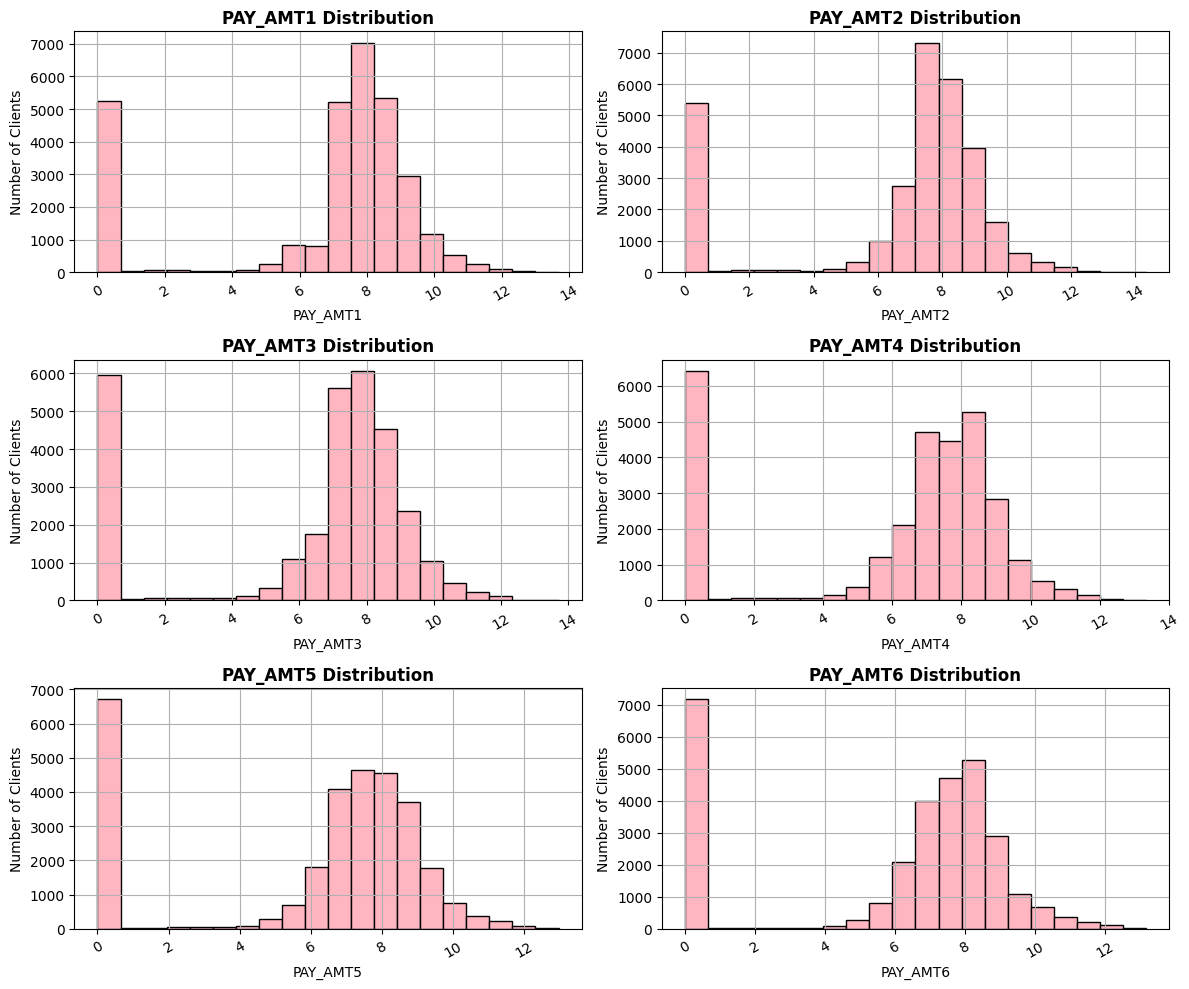

In [43]:
# Re-Check Paid amount distribution after transformation

six_distribution(df_paid)

In [44]:
# Applying Power Transformation (Yeo-Johnson) to 'BILL_AMT' Features

# Columns representing billed (outstanding) amounts over the last 6 months
cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

# Initialize PowerTransformer using Yeo-Johnson method (handles both positive & negative values)
pt = PowerTransformer(method='yeo-johnson')

# Fit and transform the selected columns to reduce skewness and stabilize variance
df_owed = pt.fit_transform(df_owed)

# Convert transformed array back to DataFrame with original column names
df_owed = pd.DataFrame(df_owed, columns=cols)

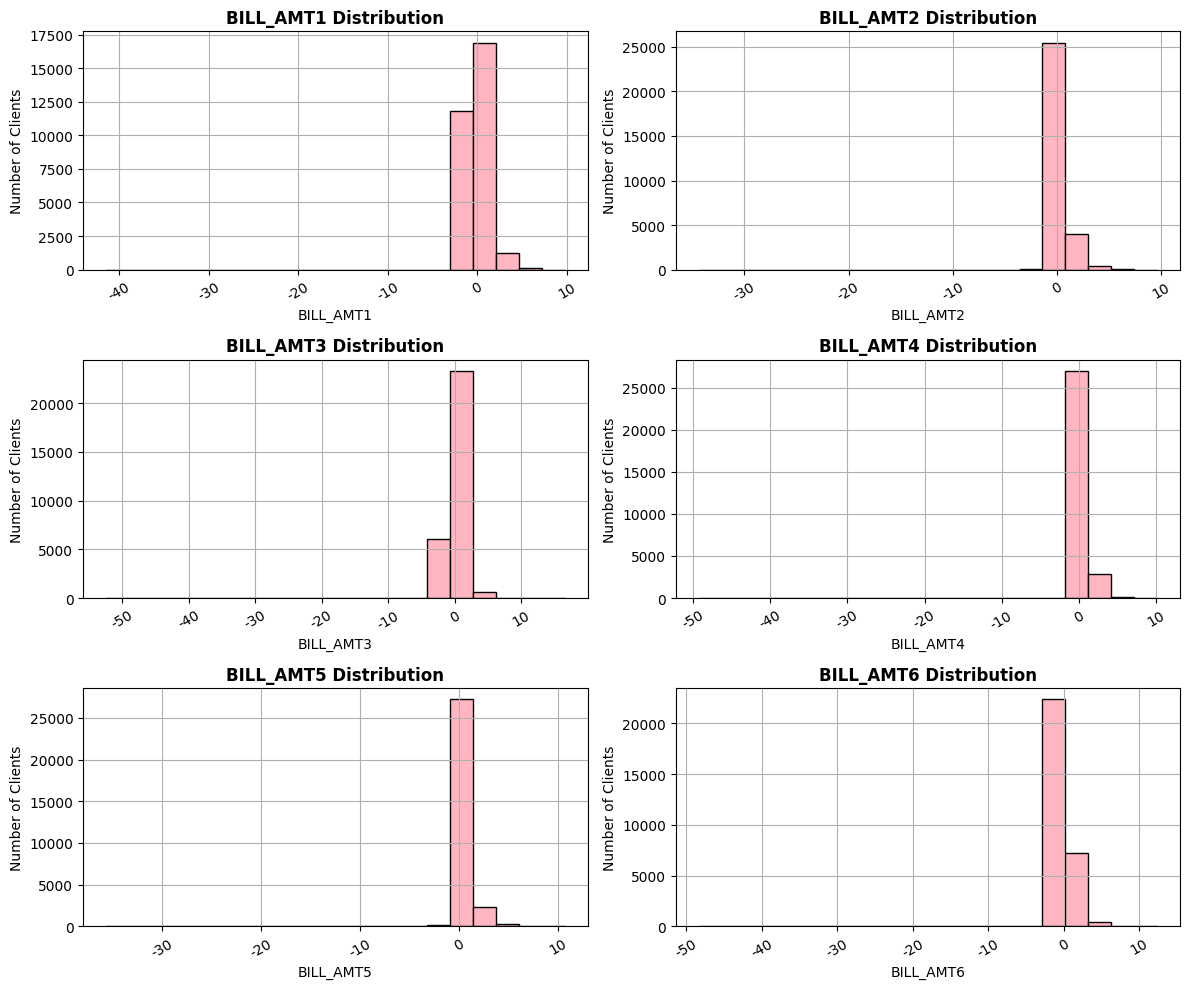

In [45]:
# Visualizing Bill Amount Distribution After Power Transformation

six_distribution(df_owed)

In [46]:
# Update Original DataFrame with Transformed Features

df[df_paid.columns] = df_paid
df[df_owed.columns] = df_owed

print("The main dataset (df) is now updated with normalized financial features to ensure better model stability and performance")


The main dataset (df) is now updated with normalized financial features to ensure better model stability and performance


### Feature Selection


In [47]:
# Define Feature Matrix (X) and Target Variable (y)

# Exclude non-predictive 'ID' column and the target column 'default' from the feature set
X = df.drop(['ID', 'default'], axis=1)

# Define target variable representing default status (0 = Non-Defaulter, 1 = Defaulter)
y = df['default']

In [48]:
# Split Dataset into Training and Testing Sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y # For balancing
)

print("Data is now split into 80% training and 20% testing sets")

Data is now split into 80% training and 20% testing sets


### Feature Scaling

In [49]:
# Feature Scaling using StandardScaler

# Initialize StandardScaler to normalize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets (Preventing data leakage by fitting only on X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features are now standardized and ready for model training")

Features are now standardized and ready for model training


In [50]:
# Convert Scaled Arrays Back to DataFrames for Inspection

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [51]:
# Display the first two rows of the scaled training dataset

X_train_scaled.head(2)

,LIMIT_BAL,SEX,EDUCATION_LEVEL,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.340007,0.80844,0.184523,0.856739,-0.158987,1.793311,1.780193,2.652046,1.911811,0.240260,...,1.798426,1.894393,1.911964,1.959780,0.918339,-2.001046,-1.873268,0.776365,0.982673,0.791001
1,0.271348,0.80844,-1.077532,0.856739,-0.040209,0.902944,-0.722324,-0.697642,-1.530826,-1.537252,...,-0.766930,-0.745853,-0.703376,-0.651783,-0.816245,-2.001046,-1.873268,-1.785923,-1.748147,-1.673047


In [52]:
# Display the first two rows of the scaled test dataset

X_test_scaled.head(2)

,LIMIT_BAL,SEX,EDUCATION_LEVEL,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.897390,-1.23695,0.184523,0.856739,1.167753,-0.877791,-0.722324,-0.697642,-0.670167,0.240260,...,-0.76693,-0.672210,-0.606112,-0.586460,1.088602,-2.001046,0.557636,0.492258,0.419678,0.575036
1,0.271348,-1.23695,-1.077532,-1.059367,-0.407401,-0.877791,-0.722324,-1.535065,-1.530826,-1.537252,...,-0.76693,-0.745853,-0.703376,-0.410884,-2.045917,-2.001046,-1.873268,-1.785923,0.968023,1.241275


## Model Building, Prediction & Evaluation

In [75]:


def evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple classification models on a given dataset.

    Parameters
    ----------
    X_train : array-like or pandas.DataFrame
        Feature matrix for training.
    X_test : array-like or pandas.DataFrame
        Feature matrix for testing.
    y_train : array-like or pandas.Series
        Target vector for training.
    y_test : array-like or pandas.Series
        Target vector for testing.

    Returns
    -------
    df_results : pandas.DataFrame
        A DataFrame containing each model’s name and metrics: Accuracy, Precision,
        Recall, F1-score, and ROC-AUC, sorted by AUC in descending order.

    trained_models : dict
        A dictionary of trained model objects, where keys are model names
        and values are the corresponding fitted estimators.
    """

    # Define candidate models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=42)
    }

    # Initialize containers for results and trained model objects
    results = []
    trained_models = {}

    # Train, predict, and evaluate each model
    for name, model in models.items():
        # Fit model on training data
        model.fit(X_train, y_train)
        trained_models[name] = model

        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Compute performance metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        # Store results
        results.append([name, acc, prec, rec, f1, auc])

    # Create a DataFrame of results and sort by AUC
    df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
    df_results = df_results.sort_values(by="AUC", ascending=False).reset_index(drop=True)

    return df_results, trained_models


In [76]:
# Evaluate baseline model performance on the original (unbalanced) dataset

results_df, models = evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)


In [77]:
# Display model performance results

results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,LightGBM,0.818500,0.661685,0.366993,0.472128,0.774928
1,Random Forest,0.817667,0.663394,0.356443,0.463725,0.758778
2,Logistic Regression,0.805667,0.662626,0.247174,0.360044,0.732567
3,XGBoost,0.788167,0.558824,0.200452,0.295064,0.686284


**Insights:**

LightGBM is your best model overall

It has the highest AUC (0.77), meaning it separates defaults vs non-defaults better than all others.

It also has the highest F1-score, showing better balance between precision and recall.

However, recall is still low (0.36) → the model misses many defaulters.

Insight: LightGBM is the strongest choice, but it still struggles to catch all default cases.

### ROC Curve Comparison

ROC Curve (Receiver Operating Characteristic Curve): It’s a graph that shows how well a classification model can separate two classes — for example, defaulters vs non-defaulters.

The curve plots:

True Positive Rate (TPR) → how many actual defaulters the model correctly predicts.

False Positive Rate (FPR) → how many non-defaulters are wrongly predicted as defaulters.

The closer the curve is to the top-left corner, the better the model is at distinguishing between the two classes.

AUC (Area Under the Curve): AUC measures the total area under the ROC curve — a single number between 0 and 1.

It tells you how well the model can separate the classes overall:

AUC = 1.0: perfect model

AUC = 0.5: no skill (random guessing)

AUC > 0.7: good model performance

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

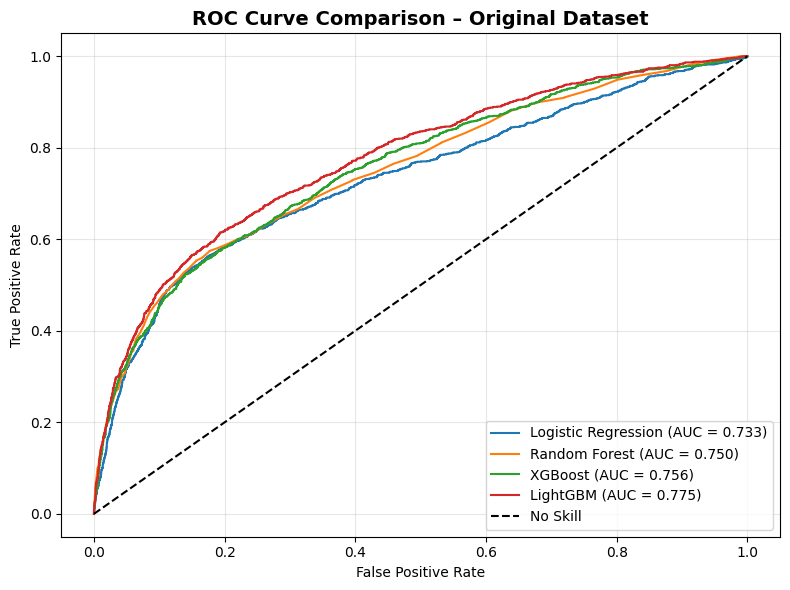

In [56]:
# Initialize a new figure for plotting
plt.figure(figsize=(8,6))

# Loop through each trained model (original data) and plot its ROC curve
for name, model in models.items():
    # Compute False Positive Rate (FPR) and True Positive Rate (TPR)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Calculate AUC (Area Under the ROC Curve)
    auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Plot the ROC curve for each model with AUC in legend
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# Plot a diagonal reference line (no-skill model baseline)
plt.plot([0,1], [0,1], 'k--', label='No Skill')

# Add title and axis labels
plt.title('ROC Curve Comparison – Original Dataset', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()

# ---- Save and download the figure ----
# Save the ROC comparison plot as a high-resolution PNG image
plt.savefig("/content/roc_comparison_original.png", dpi=300, bbox_inches='tight')

# Download the saved file to your local computer (for Google Colab)
from google.colab import files
files.download("/content/roc_comparison_original.png")

# Display the plot
plt.show()


**Insights**:

The ROC curve comparison shows that all models perform better than random guessing, with curves lying well above the diagonal line.

Among them, LightGBM demonstrates the best discrimination ability with the highest AUC (0.775), followed by XGBoost (0.756) and Random Forest (0.750).

Logistic Regression performs moderately with an AUC of 0.733, indicating it captures fewer nonlinear patterns.

Overall, ensemble tree-based models (LightGBM and XGBoost) outperform linear methods, making them more effective for predicting credit default in this dataset.

## HyperParameter Tuning for best model

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# Base model
lgbm = LGBMClassifier(random_state=42)

# Parameter search space
param_dist = {
    'num_leaves': [20, 31, 50, 70],
    'max_depth': [-1, 3, 5, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'min_child_samples': [20, 40, 80, 120],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0],
    'bagging_freq': [0, 1, 3, 5],
    'lambda_l1': [0, 1, 2],
    'lambda_l2': [0, 1, 2],

    # Handles class imbalance
    'is_unbalance': [True],
}

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=40,                       # Number of combinations to try
    scoring='roc_auc',               # Optimise AUC
    cv=3,                            # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1                        # Use all CPU cores
)

# Fit search on training data
random_search.fit(X_train, y_train)

# Best model and best parameters
print("Best AUC Score:", random_search.best_score_)
print("\nBest Hyperparameters:")
for k, v in random_search.best_params_.items():
    print(f"{k}: {v}")

# Get the final tuned model
best_lgbm = random_search.best_estimator_

# Evaluate on test set
y_prob = best_lgbm.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_prob)

print("\nTest AUC with Tuned Model:", test_auc)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best AUC Score: 0.7847636149792868

Best Hyperparameters:
num_leaves: 20
n_estimators: 200
min_child_samples: 120
max_depth: 8
learning_rate: 0.03
lambda_l2: 2
lambda_l1: 0
is_unbalance: True
feature_fraction: 0.6
bagging_freq: 3
bagging_fraction: 0.8

Test AUC with Tuned Model: 0.7797951353887095


## Re Build  model with best hyperparameter

In [80]:
from lightgbm import LGBMClassifier

# Rebuild the model using your tuned hyperparameters
best_lgbm = LGBMClassifier(
    num_leaves=20,
    n_estimators=200,
    min_child_samples=120,
    max_depth=8,
    learning_rate=0.03,
    lambda_l2=2,
    lambda_l1=0,
    is_unbalance=True,
    feature_fraction=0.6,
    bagging_freq=3,
    bagging_fraction=0.8,
    random_state=42,
    verbose=-1
)

# Fit on training data
best_lgbm.fit(X_train, y_train)

# Predict
y_pred = best_lgbm.predict(X_test)
y_prob = best_lgbm.predict_proba(X_test)[:, 1]

# Evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Create DataFrame
df_lgbm_results = pd.DataFrame([{
    "Model": "LightGBM (Tuned)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1,
    "AUC": auc
}])

df_lgbm_results

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,LightGBM (Tuned),0.762167,0.471559,0.624717,0.537439,0.779795


## Data Augmentation to balance dataset

### Apply SMOTE
* SMOTE (Synthetic Minority Over-sampling Technique) is a classical data augmentation method used for tabular data in imbalanced classification problems.

In [81]:
# Apply SMOTE to training data

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#  Scale data

scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

#  Build tuned LightGBM model

best_lgbm = LGBMClassifier(
    num_leaves=20,
    n_estimators=200,
    min_child_samples=120,
    max_depth=8,
    learning_rate=0.03,
    lambda_l2=2,
    lambda_l1=0,
    is_unbalance=True,
    feature_fraction=0.6,
    bagging_freq=3,
    bagging_fraction=0.8,
    random_state=42,
    verbose=-1
)

# Fit the model
best_lgbm.fit(X_train_smote_scaled, y_train_smote)

#  Predict + Evaluate

y_pred = best_lgbm.predict(X_test_scaled)
y_prob = best_lgbm.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

#  Create results DataFrame

smote_lgbm_df = pd.DataFrame([{
    "Model": "LightGBM (Tuned)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1,
    "AUC": auc,
    "Dataset": "SMOTE"
}])

smote_lgbm_df



,Model,Accuracy,Precision,Recall,F1-score,AUC,Dataset
0,LightGBM (Tuned),0.7895,0.524206,0.522231,0.523216,0.769631,SMOTE


## Apply SDV (CTGAN) to balance dataset by Synthetic Data Generation

* SDV’s CTGAN is a type of GAN (Generative Adversarial Network), specifically designed for tabular data generation.

In [59]:
# Import CTGAN Synthesizer for generating realistic synthetic tabular data
from sdv.single_table import CTGANSynthesizer

# Import metadata class to define the structure and data types of the real dataset
from sdv.metadata import SingleTableMetadata

# Combine training features and target into one DataFrame
train_df = X_train.copy()
train_df['default'] = y_train.values

# Initialize metadata object for a single-table dataset
metadata = SingleTableMetadata()

# Automatically detect data types, column roles, and constraints

metadata.detect_from_dataframe(data=train_df)

print("Metadata now captures the structural blueprint of your dataset ready to be used by CTGAN for synthetic data generation")


Metadata now captures the structural blueprint of your dataset ready to be used by CTGAN for synthetic data generation


In [66]:
'''# Initialize and Train CTGAN Synthesizer

ctgan = CTGANSynthesizer(metadata)

# Fit the CTGAN model on the training data
# This step trains a GAN to learn the statistical patterns of your table

print("Training CTGAN... (this may take several minutes)")

ctgan.fit(train_df)

print("CTGAN training complete.")'''

'# Initialize and Train CTGAN Synthesizer\n\nctgan = CTGANSynthesizer(metadata)\n\n# Fit the CTGAN model on the training data\n# This step trains a GAN to learn the statistical patterns of your table\n\nprint("Training CTGAN... (this may take several minutes)")\n\nctgan.fit(train_df)\n\nprint("CTGAN training complete.")'

In [68]:
'''# Save trained CTGAN model to a file
import pickle

save_path = r"/content/drive/MyDrive/Navaneeth/project/ctgan_model.pkl"  # change to your pathdefault of credit card clients.xls
with open(save_path, "wb") as f:
    pickle.dump(ctgan, f)

print("CTGAN model saved successfully to drive!")'''

'# Save trained CTGAN model to a file\nimport pickle\n\nsave_path = r"/content/drive/MyDrive/Navaneeth/project/ctgan_model.pkl"  # change to your pathdefault of credit card clients.xls\nwith open(save_path, "wb") as f:\n    pickle.dump(ctgan, f)\n\nprint("CTGAN model saved successfully to drive!")'

**Note:**

ctgan.fit(train_df) takes more than one hour , so next time we will not run this code , skipping this step we will just load saved model

In [64]:
# Load the saved model
ctgan = CTGANSynthesizer.load('/content/drive/MyDrive/Navaneeth/project/ctgan_model.pkl')
print("CTGAN model loaded successfully!")

# Now you can generate samples immediately
synthetic_data = ctgan.sample(1000)

CTGAN model loaded successfully!


In [65]:
# Generate Synthetic Minority Samples Using CTGAN

# Determine the current class imbalance
minority_count = train_df[train_df['default'] == 1].shape[0]
majority_count = train_df[train_df['default'] == 0].shape[0]

# Calculate how many new synthetic samples are needed to balance the dataset
to_generate = majority_count - minority_count
print(f"Generating {to_generate} synthetic samples...")

# Generate synthetic data using the trained CTGAN model
synthetic_data = ctgan.sample(to_generate)

# Separate features and target variable from synthetic data
X_gan_generated = synthetic_data.drop('default', axis=1)
y_gan_generated = synthetic_data['default']

print("Synthetic samples are now ready to be combined with real data for building a balanced and enriched training dataset")


Generating 13382 synthetic samples...
Synthetic samples are now ready to be combined with real data for building a balanced and enriched training dataset


In [82]:
#  Combine Real + GAN-Synthetic Samples

X_train_gan = pd.concat([X_train, X_gan_generated], axis=0)
y_train_gan = pd.concat([y_train, y_gan_generated], axis=0)

#  Scale Data

scaler = StandardScaler()
X_train_gan_scaled = scaler.fit_transform(X_train_gan)
X_test_scaled = scaler.transform(X_test)

#  Build Tuned LightGBM Model

best_lgbm = LGBMClassifier(
    num_leaves=20,
    n_estimators=200,
    min_child_samples=120,
    max_depth=8,
    learning_rate=0.03,
    lambda_l2=2,
    lambda_l1=0,
    is_unbalance=True,
    feature_fraction=0.6,
    bagging_freq=3,
    bagging_fraction=0.8,
    random_state=42,
    verbose=-1
)

# Train model
best_lgbm.fit(X_train_gan_scaled, y_train_gan)

#  Predict + Evaluate

y_pred = best_lgbm.predict(X_test_scaled)
y_prob = best_lgbm.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Create Results DataFrame

gan_lgbm_df = pd.DataFrame([{
    "Model": "LightGBM (Tuned)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1,
    "AUC": auc,
    "Dataset": "CTGAN"
}])

gan_lgbm_df


,Model,Accuracy,Precision,Recall,F1-score,AUC,Dataset
0,LightGBM (Tuned),0.768333,0.481216,0.608139,0.537284,0.77554,CTGAN


## Combine All Results into One DataFrame

In [83]:
import pandas as pd

# Ensure original df has a Dataset column
df_lgbm_results["Dataset"] = "Original"

# Combine all three
combined_lgbm_df = pd.concat([df_lgbm_results, smote_lgbm_df, gan_lgbm_df], axis=0).reset_index(drop=True)

# Optional: sort for readability
combined_lgbm_df = combined_lgbm_df.sort_values(by=["Dataset"]).reset_index(drop=True)

# Display the final comparison
combined_lgbm_df


,Model,Accuracy,Precision,Recall,F1-score,AUC,Dataset
0,LightGBM (Tuned),0.768333,0.481216,0.608139,0.537284,0.775540,CTGAN
1,LightGBM (Tuned),0.762167,0.471559,0.624717,0.537439,0.779795,Original
2,LightGBM (Tuned),0.789500,0.524206,0.522231,0.523216,0.769631,SMOTE
